The goal here is to follow this tutorial 

https://docs.pymc.io/notebooks/GLM-rolling-regression.html

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

In [2]:
import os

In [3]:
GAMMA = 1/4

I didn't know how to do this in python, so I just exported this data frame from R. 
It is a "rolling window" of cumulative cases (with the window = 20).

You can find it here: https://github.com/tvladeck/covid-rt/blob/pymc3-approach/nyc-series.csv

In [4]:
nyc = pd.read_csv('~/Repos/covid-rt/nyc-series.csv')

In [34]:
nycp1 = nyc[1:len(nyc)]
nycm1 = nyc[0:(len(nyc)-1)]

In [64]:
with pm.Model() as model_randomwalk:
    
    serial_interval = pm.Gamma('serial_interval', mu = 4, sd = 1)
    
    gamma = pm.Deterministic('gamma', 1)
    
    sigma_theta = pm.HalfNormal('sigma_theta', sd = 0.1)

    theta = pm.GaussianRandomWalk('theta', sd=sigma_theta,
                                  shape=len(nycp1.nyc))
    
    rt = pm.Deterministic('rt', theta/GAMMA + 1)
    
    likelihood = pm.Poisson('y', mu = np.exp(theta) * nycm1.nyc, observed = nycp1.nyc)

In [65]:
with model_randomwalk:
    trace_rw = pm.sample(tune=1000, cores=2,
                         target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, sigma_theta]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 364.06draws/s]


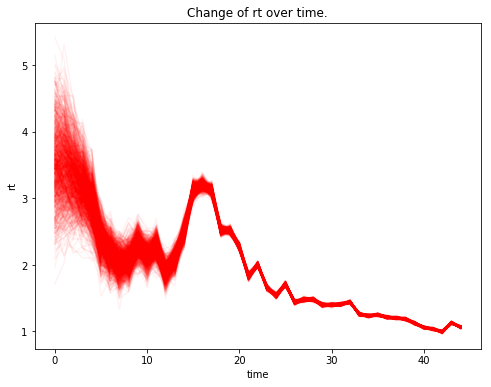

In [66]:
rt = trace_rw['rt'].T 
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='rt', title='Change of rt over time.')
ax.plot(rt, 'r', alpha=.05);

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


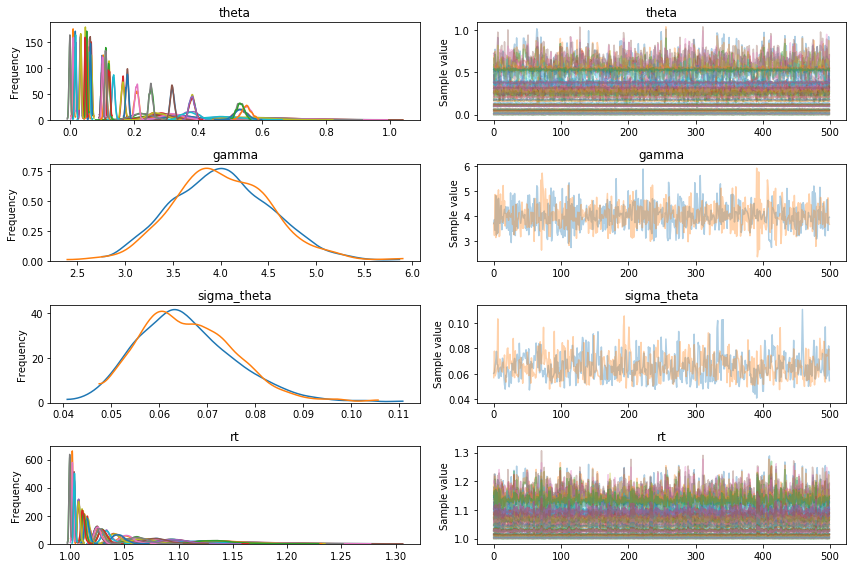

In [53]:
pm.traceplot(trace_rw);

In [57]:
ppc = pm.sample_ppc(trace_rw, samples=500, model=model_randomwalk)

100%|██████████| 500/500 [00:00<00:00, 1871.01it/s]
